<a href="https://colab.research.google.com/github/SravyaChadalavada/Harnessing-Machine-Learning-for-Reliable-Solar-Power-Generation-Forecasting/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


846/846 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - loss: 0.0282 - val_loss: 0.0125
Epoch 2/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step - loss: 0.0260 - val_loss: 0.0115
Epoch 3/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0251 - val_loss: 0.0111
Epoch 4/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0245 - val_loss: 0.0113
Epoch 5/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0245 - val_loss: 0.0110
Epoch 6/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0244 - val_loss: 0.0107
Epoch 7/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0240 - val_loss: 0.0108
Epoch 8/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0246 - val_loss: 0.0106
Epoch 9/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0232 - val_loss: 0.0104
Epoch 10/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0234 - val_loss: 0.0107
Epoch 11/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 0.0233 - val_loss: 0.0105
Epoch 12/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 

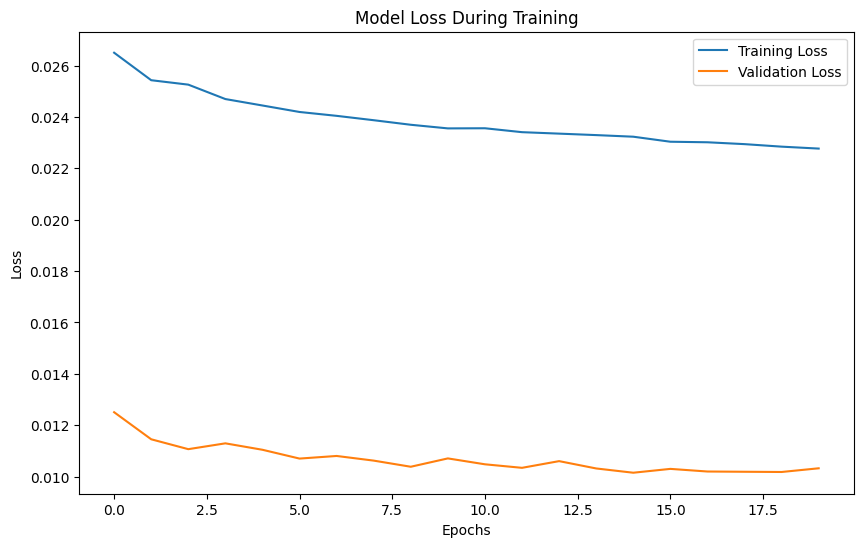

2115/2115 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step


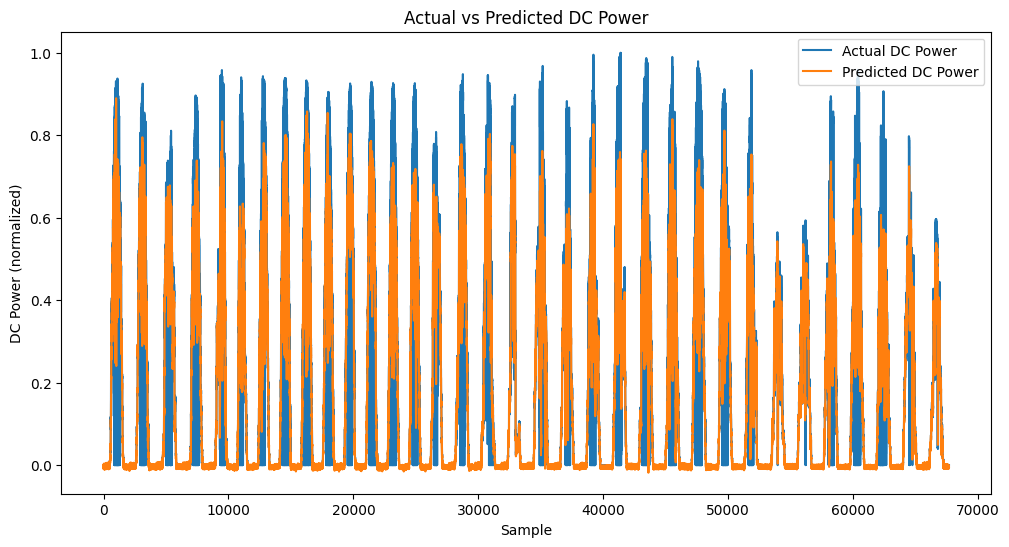

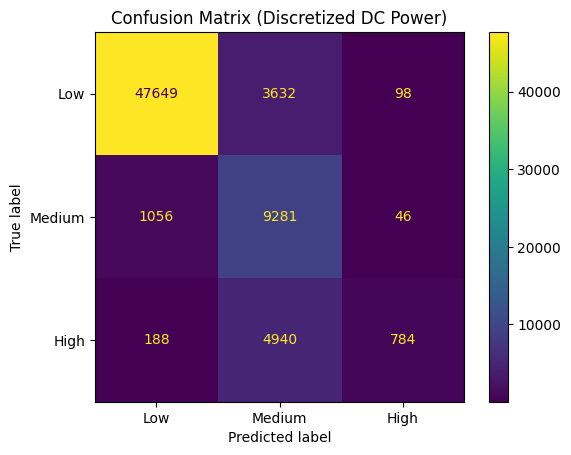

LSTM:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     51379
           1       0.52      0.89      0.66     10383
           2       0.84      0.13      0.23      5912

    accuracy                           0.85     67674
   macro avg       0.78      0.65      0.61     67674
weighted avg       0.89      0.85      0.84     67674



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
# Load the datasets
generation_data = pd.read_csv('Plant_2_Generation_Data.csv')
weather_data = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

# Merge datasets on DATE_TIME and PLANT_ID
merged_data = pd.merge(generation_data, weather_data, on=['DATE_TIME', 'PLANT_ID'], how='inner')

# Convert DATE_TIME to datetime and sort by DATE_TIME
merged_data['DATE_TIME'] = pd.to_datetime(merged_data['DATE_TIME'])
merged_data = merged_data.sort_values(by=['DATE_TIME'])

# Select features and target
features = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
target = 'DC_POWER'

# Drop rows with missing values
merged_data = merged_data.dropna(subset=features + [target])

# Normalize data
scaler = MinMaxScaler()
merged_data[features + [target]] = scaler.fit_transform(merged_data[features + [target]])

# Create sequences
def create_sequences(data, target_column, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][target_column])
    return np.array(X), np.array(y)

# Prepare the data
sequence_length = 24
X, y = create_sequences(merged_data[features + [target]].values, target_column=-1, sequence_length=sequence_length)

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X, y, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate predictions
y_pred = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y, label='Actual DC Power')
plt.plot(y_pred, label='Predicted DC Power')
plt.title('Actual vs Predicted DC Power')
plt.xlabel('Sample')
plt.ylabel('DC Power (normalized)')
plt.legend()
plt.show()

# Confusion Matrix (optional: discretize predictions into classes)
# Define thresholds for classes (low, medium, high power)
thresholds = [0.33, 0.66]  # Modify as needed based on the data distribution
y_class = np.digitize(y, bins=thresholds)
y_pred_class = np.digitize(y_pred.flatten(), bins=thresholds)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_class, y_pred_class)
ConfusionMatrixDisplay(cm, display_labels=['Low', 'Medium', 'High']).plot()
plt.title('Confusion Matrix (Discretized DC Power)')
plt.show()
print("LSTM:\n", classification_report(y_class, y_pred_class))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the data
generation_data = pd.read_csv('/content/Plant_2_Generation_Data.csv')
weather_station_data = pd.read_csv('/content/Plant_2_Weather_Sensor_Data.csv')
df_solar = pd.merge(
    generation_data.drop(columns=['PLANT_ID']),
    weather_station_data.drop(columns=['PLANT_ID', 'SOURCE_KEY']),
    on='DATE_TIME'
)

# Drop unnecessary columns
df_solar = df_solar.drop(columns=['SOURCE_KEY', 'DATE_TIME'])

# Separate features and target variable
X = df_solar.drop(columns=['TOTAL_YIELD']).values
y = df_solar['TOTAL_YIELD'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mape'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae, mape = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Test RMSE: {rmse}")

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f"Test R-squared: {r2}")

# Display all metrics
print("Predictions:", predictions)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1354/1354 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 976348389681659904.0000 - mae: 663261248.0000 - mape: 643627745280.0000 - val_loss: 958787264840728576.0000 - val_mae: 653044288.0000 - val_mape: 16716761399296.0000
Epoch 2/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 957850480933863424.0000 - mae: 654963840.0000 - mape: 41843047792640.0000 - val_loss: 924901003667439616.0000 - val_mae: 640433984.0000 - val_mape: 195733454061568.0000
Epoch 3/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 913882385328635904.0000 - mae: 638550528.0000 - mape: 285883425095680.0000 - val_loss: 836019782212911104.0000 - val_mae: 610227392.0000 - val_mape: 713557947711488.0000
Epoch 4/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 829469647848865792.0000 - mae: 616771008.0000 - mape: 952631128227840.0000 - val_loss: 712474188950011904.0000 - val_mae: 592617984.0000 - val_mape: 1620655711715328.0000
Epoch 5/50
1354/1354 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 698749947373158400.0000 -

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load and merge the datasets
generation_data = pd.read_csv('Plant_2_Generation_Data.csv')
weather_data = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')
merged_data = pd.merge(generation_data, weather_data, on=['DATE_TIME', 'PLANT_ID'], how='inner')
merged_data['DATE_TIME'] = pd.to_datetime(merged_data['DATE_TIME'])
merged_data = merged_data.sort_values(by=['DATE_TIME'])

# Select features and target
features = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
target = 'DC_POWER'
merged_data = merged_data.dropna(subset=features + [target])

# Log-transform target variable for stability
merged_data[target] = np.log1p(merged_data[target])

# Normalize data
scaler = MinMaxScaler()
merged_data[features + [target]] = scaler.fit_transform(merged_data[features + [target]])

# Create sequences for time series
def create_sequences(data, target_column, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][target_column])
    return np.array(X), np.array(y)

# Prepare the data
sequence_length = 24
X, y = create_sequences(merged_data[features + [target]].values, target_column=-1, sequence_length=sequence_length)

# Define the optimized LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, X.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions and evaluation metrics
y_pred = model.predict(X)
y_pred = np.expm1(y_pred)  # Reverse the log transform on predictions
y_true = np.expm1(y)       # Reverse the log transform on actual values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R-squared: {r2}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual DC Power')
plt.plot(y_pred.flatten(), label='Predicted DC Power')
plt.title('Actual vs Predicted DC Power')
plt.xlabel('Sample')
plt.ylabel('DC Power')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - loss: 0.1063 - val_loss: 0.0374
Epoch 2/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - loss: 0.0435 - val_loss: 0.0226
Epoch 3/20
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - loss: 0.0399 - val_loss: 0.0305
Epoch 4/20
 545/1692 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - loss: 0.0405